<a href="https://colab.research.google.com/github/MarehWilliams01/final/blob/main/assessing_xenophobia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing the neccessary libraries
import numpy as np
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
#setting up the cleaned xenophobia dataset from kaggle

data = pd.read_csv('/content/drive/MyDrive/Datasets/SA_XenoDataset_2017-2022.csv')
df = pd.DataFrame(data.drop(columns=[ 'Unnamed: 0','Likes', 'No of replies', 'Language', 'Coordinates', 'Number of Attacks','Sentiment', 'User Location' ,'District', 'Province'], axis=1)) #converting it to dataframe

#converting 'TimeCreated' and 'DateCreated' to be of the type datetime
#for 'TimeCreated' column
df['TimeCreated'] = pd.to_datetime(df['TimeCreated'])
df['TimeCreated'] = pd.to_datetime(df['TimeCreated'], format='%H:%M:%S').dt.time

#for 'DateCreated' column
df['DateCreated'] = pd.to_datetime(df['DateCreated'])
df['DateCreated'] = df['DateCreated'].dt.date

# Combine 'DateCreated' and 'TimeCreated' columns into a single datetime column
df['DateTimeCreated'] = pd.to_datetime(df['DateCreated'].astype(str) + ' ' + df['TimeCreated'].astype(str))

# Extract year from 'DateTimeCreated' and create a new column
df['Year'] = df['DateTimeCreated'].dt.year

#dropping rows with NaN Inputs
df= df.dropna()

df

In [ ]:
#Preprocessing tweets
df['CleanedTweet'].apply(type)

In [ ]:
# Developing a dictionary for shorthand texts
# Send a GET request
url = "https://messente.com/blog/text-abbreviations"
response = requests.get(url)

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(response.content, "html.parser")

# Find the second and third b tags and extract the data
b_tags = soup.find_all("b")
second_b_tag = b_tags[1]
third_b_tag = b_tags[2]

# Find all paragraphs inside the second and third b tags, excluding the first paragraph
second_paragraphs = second_b_tag("p")[1:]
third_paragraphs = third_b_tag("p")[1:]

# Extract the slang words and descriptions
slang_list = []
description_list = []
count = 0

for paragraph in second_paragraphs + third_paragraphs:
  if count <= 99:
    split_text = paragraph.text.strip().split(" – ", 1)
    slang = split_text[0].split(". ", 1)[-1].lower()
    description = split_text[1] if len(split_text) > 1 else ""
    slang_list.append(slang)
    description_list.append(description)
    count += 1

  else:
    break

# Create a DataFrame from the extracted data
df_slangs = pd.DataFrame({
    "slang": slang_list,
    "description": description_list
})

# Print the DataFrame
print(df_slangs)

In [ ]:
# Preprocessing the data

# Developing a function to clean the data
def clean_tweet(text):
  words = text.split() # splits text into each word
  normalized_words = [df_slangs.loc[df_slangs['slang'] == word, "description"].values[0]
    if word in df_slangs['slang'].values else word for word in words] # removes slangs
  text = " ".join(normalized_words)

  return text.lower()

# Checking for NaN values in the 'CleanedTweet' column
df['CleanedTweet'] = df['CleanedTweet'].apply(clean_tweet)

df['CleanedTweet']

In [ ]:
# Lemmatization

nlp = spacy.load("en_core_web_sm")

# Function to lemmatize each word in a tweet
def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

# Apply lemmatization to the 'CleanedTweet' column
df['CleanedTweet'] = df['CleanedTweet'].apply(lemmatize_text)

df['CleanedTweet']

In [ ]:
# Removing stopwords

# Getting the current list of English stopwords
stopword_list = stopwords.words('english')

# Function to remove stopwords from tweet
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    text = ' '.join(filtered_tokens)
    return text

# Apply stopword removal to the tweet column
df['CleanedTweet'] = df['CleanedTweet'].apply(remove_stopwords)

df['CleanedTweet']

In [23]:

# Function to get sentiment using TextBlob
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment analysis function to the tweet column
df['Sentiment'] = df['CleanedTweet'].apply(get_sentiment)

df

,DateCreated,TimeCreated,CleanedTweet,Retweets,Tweet Origin,DateTimeCreated,Year,Sentiment,SentimentNumeric
0,2022-07-18,20:57:33,Where are the foreigners? We were told maRus...,1,Centurion,2022-07-18 20:57:33,2022,Neutral,0
1,2022-07-18,20:15:58,We invite all those who have lost loved ones t...,0,Johannesburg,2022-07-18 20:15:58,2022,Positive,1
2,2022-07-18,20:03:16,"After battling with HIV/AIDS for years, South ...",18,Pretoria,2022-07-18 20:03:16,2022,Positive,1
3,2022-07-18,15:03:18,Nani impela seniyamthemba UCele nama phoyisa....,0,Johannesburg,2022-07-18 15:03:18,2022,Negative,-1
4,2022-07-18,14:41:14,Give Nhlanhla his flowers for release himse...,0,Johannesburg,2022-07-18 14:41:14,2022,Negative,-1
...,...,...,...,...,...,...,...,...,...
15907,2017-01-09,04:38:47,Those foreigners who talk nonsense about ANC&a...,0,Kwadabeka,2017-01-09 04:38:47,2017,Neutral,0
15908,2017-01-06,19:12:13,ANC must educate black children that FF+ whi...,0,Durban,2017-01-06 19:12:13,2017,Negative,-1
15909,2017-01-06,10:01:23,The day police nyalas n officers round up whit...,2,Johannesburg,2017-01-06 10:01:23,2017,Negative,-1
15910,2017-01-05,07:17:36,Ive noticed and that abelungu abama foreigners...,6,Durban,2017-01-05 07:17:36,2017,Positive,1


In [ ]:
# analyzing sentiment on xenophobia tweets over time

#seeing the different dates used in the dataset
# Get unique time values
unique_times = df['DateCreated'].unique()

# Display unique time values
for time_val in unique_times:
    print(time_val)


# Group the data by year and sentiment, and count the sentiments
sentiment_counts = df.groupby(['Year', 'Sentiment']).size().unstack(fill_value=0)

# Display the result
print(sentiment_counts)


In [ ]:
# finding the average sentiment of xenophobia-related tweets over time in years

# Function to map sentiment labels to numerical values
def map_sentiment_to_numeric(sentiment):
    if sentiment == 'Negative':
        return -1
    elif sentiment == 'Positive':
        return 1
    else:
        return 0

# Apply the mapping function to the 'Sentiment' column and create a new column
df['SentimentNumeric'] = df['Sentiment'].apply(map_sentiment_to_numeric)

# Extract year from 'DateTimeCreated' and create a new column
df['Year'] = df['DateTimeCreated'].dt.year

# Group the data by year and sentiment, and calculate the most common sentiment
sentiment_counts = df.groupby(['Year', 'SentimentNumeric']).size().unstack(fill_value=0)
most_common_sentiment = sentiment_counts.idxmax(axis=1)

# Create the line chart
plt.figure(figsize=(10, 6))
most_common_sentiment.plot(kind='line', marker='o')
plt.title('Average Sentiment of Xenophobia-Related Tweets Over Time')
plt.xlabel('Year')
plt.ylabel('Average Sentiment')
plt.grid(True)
plt.show()


In [ ]:
# Group the data by year and sentiment, and calculate the most common sentiment
sentiment_counts = df.groupby(['Tweet Origin', 'Sentiment']).size().unstack(fill_value=0)
most_common_sentiment = sentiment_counts.idxmax(axis=1)

# Create a bar plot to visualize sentiment variations across regions
plt.figure(figsize=(50, 20))
plt.scatter(most_common_sentiment.index, most_common_sentiment.values, color='skyblue')
plt.xlabel('Region', fontsize=14)
plt.ylabel('Average Sentiment Score', fontsize=14)
plt.title('Sentiment Variations Across Different Regions', fontsize=16)
plt.xticks(rotation=45, fontsize=17)
plt.yticks(fontsize=17)
plt.tight_layout()

# Show the plot
plt.show()

<Figure size 3000x5600 with 0 Axes>

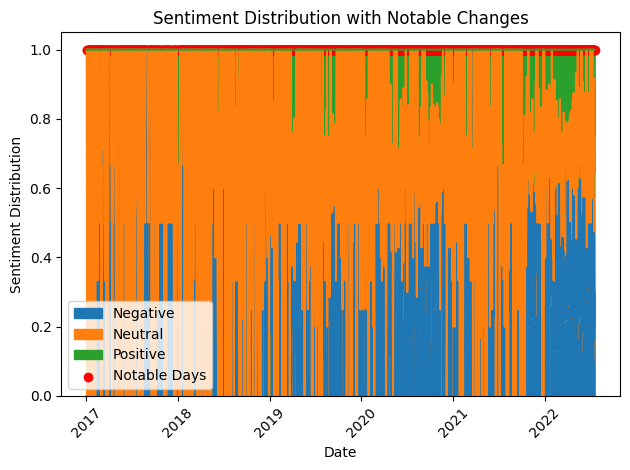

In [14]:
# Convert 'DateCreated' and 'TimeCreated' columns to datetime
df['DateCreated'] = pd.to_datetime(df['DateCreated'])
df['TimeCreated'] = pd.to_datetime(df['TimeCreated'], format='%H:%M:%S').dt.time

# Combine 'DateCreated' and 'TimeCreated' columns into a single datetime column
df['DateTimeCreated'] = pd.to_datetime(df['DateCreated'].astype(str) + ' ' + df['TimeCreated'].astype(str))

# Extract date
df['Date'] = df['DateTimeCreated'].dt.date

# Calculate sentiment distribution for each day
sentiment_distribution = df.groupby(['Date', 'Sentiment']).size().unstack(fill_value=0)
sentiment_distribution_percentage = sentiment_distribution.div(sentiment_distribution.sum(axis=1), axis=0)

# Calculate overall sentiment distribution
overall_sentiment_distribution = sentiment_distribution.sum() / sentiment_distribution.sum().sum()

# Set a threshold for detecting significant changes (e.g., 0.05)
threshold = 0.05

# Identify days with notable changes in sentiment distribution
notable_days = sentiment_distribution_percentage[
    (sentiment_distribution_percentage - overall_sentiment_distribution).abs().sum(axis=1) > threshold
]

# Plot the sentiment distribution and mark notable days
plt.figure(figsize=(30, 56))
sentiment_distribution_percentage.plot(kind='area', stacked=True)
plt.scatter(notable_days.index, [1] * len(notable_days), color='red', label='Notable Days')
plt.xlabel('Date')
plt.ylabel('Sentiment Distribution')
plt.title('Sentiment Distribution with Notable Changes')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


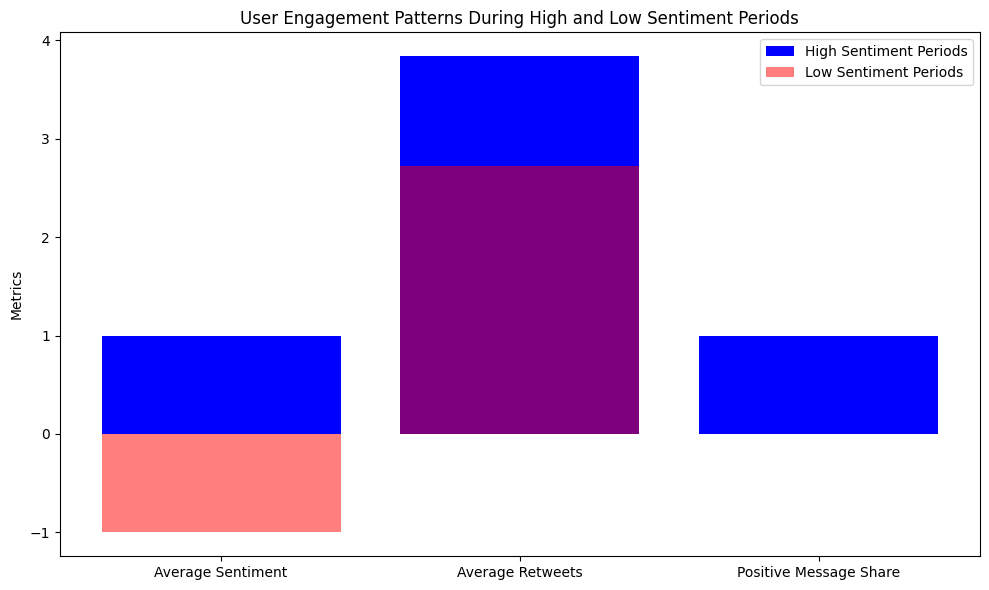

In [18]:
# Define high and low sentiment thresholds
high_sentiment_threshold = 0.5
low_sentiment_threshold = -0.5

# Segment data into high and low sentiment periods
high_sentiment_periods = df[df['SentimentNumeric'] > high_sentiment_threshold]
low_sentiment_periods = df[df['SentimentNumeric'] < low_sentiment_threshold]

# Function to calculate user engagement metrics
def calculate_engagement_metrics(data):
    avg_sentiment = data['SentimentNumeric'].mean()
    retweet_count = data['Retweets'].mean()
    positive_message_share = data[data['Sentiment'] == 'Positive'].shape[0] / data.shape[0]
    return avg_sentiment, retweet_count, positive_message_share

# Calculate engagement metrics for high sentiment periods
high_avg_sentiment, high_retweet_count, high_positive_share = calculate_engagement_metrics(high_sentiment_periods)

# Calculate engagement metrics for low sentiment periods
low_avg_sentiment, low_retweet_count, low_positive_share = calculate_engagement_metrics(low_sentiment_periods)

# Create a bar chart to visualize user engagement metrics
metrics = ['Average Sentiment', 'Average Retweets', 'Positive Message Share']
high_values = [high_avg_sentiment, high_retweet_count, high_positive_share]
low_values = [low_avg_sentiment, low_retweet_count, low_positive_share]

plt.figure(figsize=(10, 6))
plt.bar(metrics, high_values, color='blue', label='High Sentiment Periods')
plt.bar(metrics, low_values, color='red', label='Low Sentiment Periods', alpha=0.5)
plt.ylabel('Metrics')
plt.title('User Engagement Patterns During High and Low Sentiment Periods')
plt.legend()
plt.tight_layout()
plt.show()
